## 1. Loading data

Imports, config, and paths.

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from copy import deepcopy

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from xgboost import XGBRegressor, Booster
import xgboost as xgb  # for Booster (load/save)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')


# Reproducibility
seed = 42
rng = np.random.default_rng(seed)

# Target QoT metric for regression — choose "SNR" (you can switch to "OSNR")
TARGET = "OSNR"#"BER"#"SNR"

# Conformal coverage target (1 - alpha). Example: 90%
ALPHAS = [0.10]  # you can add [0.10, 0.05] to compare 90% vs 95%

# Where your CSVs live (adjust if needed)
base_path = Path('/path/to/your/csv/files')

# Whether to include meta columns as model features (usually False when testing cross-domain generalization)
INCLUDE_META_AS_FEATURES = False

# Wheter to perform preprocessing
PREPROCESSING = True # False

# Wheter perfrom missing value analysis and handle them
MISSING_VALUES = True # False


# Grouping for group-conditional (Mondrian) conformal: choose one
# Options: "dataset_id"  OR  "sdm_scenario" (combines fiber + amplifier)  OR  "topology"
GROUP_KEY = "dataset_id"

## 2. Preprocess and prepare data

One-time preprocessing and filtering (optional).

In [2]:
if PREPROCESSING:
    
    dataset_info = {
        1: {'topology': 'CONUS', 'fiber': 'Bu-SMFs', 'amplifier': 'Std EDFAs', 'switching': 'J-Sw'},
        7: {'topology': 'CONUS', 'fiber': 'WC-MCFs', 'amplifier': 'SDM Amp', 'switching': 'J-Sw'}
    }
    

    def load_all_sdm(base_path: Path, dataset_info: dict) -> pd.DataFrame:
        frames = []
        for i in dataset_info:
            fp = base_path / f"dataset-{i:02d}.csv"
            if not fp.exists():
                print(f"[WARN] Missing file: {fp}")
                continue
            df = pd.read_csv(fp)
            df = df.copy()
            df['dataset_id'] = i
            df['topology'] = dataset_info[i]['topology']
            df['fiber_type'] = dataset_info[i]['fiber']
            df['amplifier_type'] = dataset_info[i]['amplifier']
            df['switching_type'] = dataset_info[i]['switching']
            frames.append(df)
            print(f"Loaded dataset-{i:02d}: {df.shape}")
        if not frames:
            raise FileNotFoundError("No datasets loaded.")
        combined = pd.concat(frames, ignore_index=True)
        # Construct SDM scenario grouping: Bu-SMFs vs WC-MCFs (Std) vs WC-MCFs (SDM Amp)
        def scenario(row):
            if row['fiber_type'] == 'Bu-SMFs':
                return 'Bu-SMFs'
            if row['fiber_type'] == 'WC-MCFs' and row['amplifier_type'] == 'Std EDFAs':
                return 'WC-MCFs-Std'
            if row['fiber_type'] == 'WC-MCFs' and row['amplifier_type'] == 'SDM Amp':
                return 'WC-MCFs-SDM'
            return 'Other'
        combined['sdm_scenario'] = combined.apply(scenario, axis=1)
        return combined

    combined_df = load_all_sdm(base_path, dataset_info)
    print("Combined shape:", combined_df.shape)

Loaded dataset-01: (860276, 45)
Loaded dataset-07: (877840, 45)
Combined shape: (1738116, 46)


### Missing value analysis

In [3]:
if PREPROCESSING:
    if MISSING_VALUES:
        # Check for missing values per dataset (only NaN and spaces, not small numbers)
        print("Missing values per dataset:")

        def is_missing_value(val):
            """Check if a value is missing (NaN or whitespace string)"""
            if pd.isna(val):
                return True
            if isinstance(val, str) and val.strip() == '':
                return True
            return False

        for dataset_id in sorted(combined_df['dataset_id'].unique()):
            dataset_data = combined_df[combined_df['dataset_id'] == dataset_id]
            
            print(f"\nDataset {dataset_id:02d}:")
            missing_found = False
            
            for col_name in dataset_data.columns:
                # Count missing values using our custom function
                missing_count = dataset_data[col_name].apply(is_missing_value).sum()
                
                if missing_count > 0:
                    missing_found = True
                    col_index = combined_df.columns.get_loc(col_name) + 1
                    print(f"  {col_name} (x_{col_index}): {missing_count}")
            
            if missing_found:
                # Count total rows with any missing values
                total_missing_rows = dataset_data.apply(lambda row: any(is_missing_value(val) for val in row), axis=1).sum()
                pct_missing = total_missing_rows / len(dataset_data)
                print(f"  Total rows with missing values: {total_missing_rows} ({pct_missing:.2%})")
            else:
                print(f"  No missing values")

        # Overall summary
        print("\n" + "="*50)
        print("Overall missing values summary:")

        overall_missing_found = False
        for col_name in combined_df.columns:
            # Count missing values using our custom function
            missing_count = combined_df[col_name].apply(is_missing_value).sum()
            
            if missing_count > 0:
                overall_missing_found = True
                col_index = combined_df.columns.get_loc(col_name) + 1
                print(f"{col_name} (x_{col_index}): {missing_count}")

        if overall_missing_found:
            total_missing_rows = combined_df.apply(lambda row: any(is_missing_value(val) for val in row), axis=1).sum()
            pct_missing = total_missing_rows / len(combined_df)
            print(f"\nTotal rows with any missing values: {total_missing_rows}")
            print(f"Percentage of rows with missing values: {pct_missing:.2%}")
        else:
            print("No missing values found in the dataset!")


Missing values per dataset:

Dataset 01:
  max_BER (x_22): 8329
  min_BER (x_23): 8329
  avg_BER (x_24): 8329
  min_mod_for_cardinality_left (x_25): 225190
  max_mod_for_cardinality_left (x_26): 225190
  min_mod_for_cardinality_right (x_27): 306158
  max_mod_for_cardinality_right (x_28): 306158
  min_lightpath_datarate_left (x_29): 225190
  max_lightpath_datarate_left (x_30): 225190
  min_lightpath_datarate_right (x_31): 306158
  max_lightpath_datarate_right (x_32): 306158
  min_BER_left (x_33): 225190
  max_BER_left (x_34): 225190
  min_BER_right (x_35): 306158
  max_BER_right (x_36): 306158
  Total rows with missing values: 415157 (48.26%)

Dataset 07:
  max_BER (x_22): 5042
  min_BER (x_23): 5042
  avg_BER (x_24): 5042
  min_mod_for_cardinality_left (x_25): 228806
  max_mod_for_cardinality_left (x_26): 228806
  min_mod_for_cardinality_right (x_27): 301266
  max_mod_for_cardinality_right (x_28): 301266
  min_lightpath_datarate_left (x_29): 228806
  max_lightpath_datarate_left (x_30):

In [4]:
if PREPROCESSING:
    if MISSING_VALUES:
        # Check if certain features consistently have missing values across all datasets
        print("\n" + "="*70)
        print("Features with missing values consistently across ALL datasets:")
        print("="*70)

        # Get list of all unique dataset IDs
        unique_datasets = combined_df['dataset_id'].unique()
        num_datasets = len(unique_datasets)

        # Dictionary to track which features have missing values in each dataset
        feature_missing_by_dataset = {}

        # For each dataset, track which features have missing values
        for dataset_id in unique_datasets:
            dataset_data = combined_df[combined_df['dataset_id'] == dataset_id]
            features_with_missing = []
            
            for col_name in dataset_data.columns:
                missing_count = dataset_data[col_name].apply(is_missing_value).sum()
                if missing_count > 0:
                    features_with_missing.append(col_name)
            
            feature_missing_by_dataset[dataset_id] = features_with_missing

        # Find features that have missing values in ALL datasets
        all_features = set(combined_df.columns)
        features_missing_in_all = []

        for feature in all_features:
            datasets_with_missing = sum(1 for dataset_features in feature_missing_by_dataset.values() 
                                    if feature in dataset_features)
            
            if datasets_with_missing == num_datasets:
                features_missing_in_all.append(feature)

        if features_missing_in_all:
            print(f"Found {len(features_missing_in_all)} feature(s) with missing values in ALL {num_datasets} datasets:")
            for feature in features_missing_in_all:
                col_index = combined_df.columns.get_loc(feature) + 1
                total_missing = combined_df[feature].apply(is_missing_value).sum()
                print(f"  {feature} (x_{col_index}): {total_missing} total missing values")
        else:
            print("No features have missing values consistently across ALL datasets.")

        # Also check features missing in most datasets (e.g., 80% or more)
        threshold = 0.8
        features_missing_in_most = []

        for feature in all_features:
            datasets_with_missing = sum(1 for dataset_features in feature_missing_by_dataset.values() 
                                    if feature in dataset_features)
            missing_ratio = datasets_with_missing / num_datasets
            
            if missing_ratio >= threshold and datasets_with_missing < num_datasets:
                features_missing_in_most.append((feature, datasets_with_missing, missing_ratio))

        if features_missing_in_most:
            print(f"\nFeatures with missing values in ≥{threshold:.0%} of datasets ({int(threshold*num_datasets)}+ out of {num_datasets}):")
            for feature, count, ratio in features_missing_in_most:
                col_index = combined_df.columns.get_loc(feature) + 1
                total_missing = combined_df[feature].apply(is_missing_value).sum()
                print(f"  {feature} (x_{col_index}): missing in {count}/{num_datasets} datasets ({ratio:.1%}) - {total_missing} total missing")


Features with missing values consistently across ALL datasets:
Found 15 feature(s) with missing values in ALL 2 datasets:
  min_BER_right (x_35): 607424 total missing values
  min_lightpath_datarate_left (x_29): 453996 total missing values
  max_lightpath_datarate_left (x_30): 453996 total missing values
  min_mod_for_cardinality_right (x_27): 607424 total missing values
  max_BER_left (x_34): 453996 total missing values
  max_BER_right (x_36): 607424 total missing values
  max_mod_for_cardinality_right (x_28): 607424 total missing values
  min_BER (x_23): 13371 total missing values
  avg_BER (x_24): 13371 total missing values
  min_lightpath_datarate_right (x_31): 607424 total missing values
  max_BER (x_22): 13371 total missing values
  max_lightpath_datarate_right (x_32): 607424 total missing values
  min_mod_for_cardinality_left (x_25): 453996 total missing values
  min_BER_left (x_33): 453996 total missing values
  max_mod_for_cardinality_left (x_26): 453996 total missing values


### Remove features with missing values

In [5]:
if PREPROCESSING:
    if MISSING_VALUES:
        # Remove features that have missing values in ALL datasets
        if features_missing_in_all:
            print(f"\nRemoving {len(features_missing_in_all)} feature(s) that have missing values in ALL datasets:")
            for feature in features_missing_in_all:
                print(f"  Removing: {feature}")
            
            # Drop these features from the combined dataframe
            combined_df = combined_df.drop(columns=features_missing_in_all)
            print(f"Combined dataframe shape after removal: {combined_df.shape}")
        else:
            print("\nNo features to remove (none have missing values in all datasets).")
        
        # Remove features that have missing values in most datasets (≥80%)
        if features_missing_in_most:
            features_to_remove = [feature for feature, count, ratio in features_missing_in_most]
            print(f"\nRemoving {len(features_to_remove)} feature(s) that have missing values in ≥{threshold:.0%} of datasets:")
            for feature in features_to_remove:
                print(f"  Removing: {feature}")
            
            # Drop these features from the combined dataframe
            combined_df = combined_df.drop(columns=features_to_remove)
            print(f"Combined dataframe shape after removal: {combined_df.shape}")
        else:
            print("\nNo features to remove (none have missing values in ≥80% of datasets).")



Removing 15 feature(s) that have missing values in ALL datasets:
  Removing: min_BER_right
  Removing: min_lightpath_datarate_left
  Removing: max_lightpath_datarate_left
  Removing: min_mod_for_cardinality_right
  Removing: max_BER_left
  Removing: max_BER_right
  Removing: max_mod_for_cardinality_right
  Removing: min_BER
  Removing: avg_BER
  Removing: min_lightpath_datarate_right
  Removing: max_BER
  Removing: max_lightpath_datarate_right
  Removing: min_mod_for_cardinality_left
  Removing: min_BER_left
  Removing: max_mod_for_cardinality_left
Combined dataframe shape after removal: (1738116, 31)

No features to remove (none have missing values in ≥80% of datasets).


In [ ]:
if PREPROCESSING:
    if MISSING_VALUES:
        # Check for missing values in the final combined dataframe after feature removal
        print("=== Final Missing Value Check ===")
        print(f"Combined dataframe shape: {combined_df.shape}")

        # Check for any remaining missing values
        missing_counts = combined_df.isnull().sum()
        missing_features = missing_counts[missing_counts > 0]

        if len(missing_features) > 0:
            print(f"\nFound {len(missing_features)} features with missing values:")
            for feature, count in missing_features.items():
                percentage = (count / len(combined_df)) * 100
                col_index = combined_df.columns.get_loc(feature) + 1
                print(f"  {feature} (x_{col_index}): {count} missing ({percentage:.2f}%)")
            
            print(f"\nTotal missing values across all features: {missing_counts.sum()}")
        else:
            print("\n✓ No missing values found in the combined dataframe!")

        # Check for infinite values as well
        inf_counts = combined_df.select_dtypes(include=[np.number]).apply(lambda x: np.isinf(x).sum())
        inf_features = inf_counts[inf_counts > 0]

        if len(inf_features) > 0:
            print(f"\nFound {len(inf_features)} numeric features with infinite values:")
            for feature, count in inf_features.items():
                print(f"  {feature}: {count} infinite values")
        else:
            print("✓ No infinite values found in numeric features!")


        # Save the filtered combined dataframe and reload it
        print("=== Saving Filtered Data ===")

        # Save to CSV
        output_path = "path/to/your/csv/files/combined_df_filtered.csv"
        combined_df.to_csv(output_path, index=False)
        #print(f"Saved filtered combined dataframe to: {output_path}")
        print(f"Shape: {combined_df.shape}")
        print("✓ Data successfully saved!")


=== Final Missing Value Check ===
Combined dataframe shape: (1738116, 31)

✓ No missing values found in the combined dataframe!
✓ No infinite values found in numeric features!
=== Saving Filtered Data ===
Shape: (1738116, 31)
✓ Data successfully saved!


### Load preprocessed dataset

In [ ]:
# Reload from CSV
output_path = "path/to/your/csv/files/combined_df_filtered.csv"
combined_df = pd.read_csv(output_path)
#print(f"Reloaded combined dataframe from: {output_path}")
print(f"Shape after reload: {combined_df.shape}")
print("✓ Data successfully loaded!")


Shape after reload: (1738116, 31)
✓ Data successfully loaded!


## 3. Selecting groups

Feature matrix X / target y, plus grouping.

In [8]:
ALL_COLUMNS = list(combined_df.columns)

# Meta columns we never feed as raw numeric features
META_COLS = [
    'dataset_id', 'topology', 'fiber_type', 'amplifier_type', 'switching_type',
    'sdm_scenario', 'connection_id'
]
# Columns that leak the label or should be excluded
LEAKY_COLS = [
    TARGET, 'OSNR', 'BER', 'class', 'SNR'  # remove target and label-like metrics
]

# Candidate numeric features = everything numeric except leaky/meta
num_cols = [
    c for c in combined_df.columns
    if pd.api.types.is_numeric_dtype(combined_df[c])
    and c not in LEAKY_COLS
    and c not in META_COLS
]

# Optional: include meta as features via one-hot (set flag above)
cat_cols = []
if INCLUDE_META_AS_FEATURES:
    cat_cols = ['topology', 'fiber_type', 'amplifier_type', 'switching_type', 'sdm_scenario']

# Final X, y, groups
X = combined_df[num_cols + cat_cols].copy()
y = combined_df[TARGET].astype(float).values

# Convert target (OSNR) to dB safely
y = 10 * np.log10(np.maximum(combined_df[TARGET].astype(float).values, 1e-12))
groups = combined_df[GROUP_KEY].astype(str).values  # for Mondrian grouping & stratified split

print("Numeric feature count:", len(num_cols))
print("Categorical feature count:", len(cat_cols))
print("Group key:", GROUP_KEY, "| Unique groups:", np.unique(groups))

Numeric feature count: 20
Categorical feature count: 0
Group key: dataset_id | Unique groups: ['1' '7']


### Preprocessor & base regressor (XGB params)

In [9]:
# Preprocess: one-hot for categorical, passthrough for numeric
pre = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ],
    remainder="drop"
)

xgb_params = dict(
    eta=0.2,
    max_depth=9,
    subsample=0.9,
    colsample_bytree=1.0,
    n_estimators=500,
    reg_lambda=1.0,
    random_state=seed,
    tree_method="hist",
    n_jobs=-1
)

reg = XGBRegressor(**xgb_params)

model = Pipeline(steps=[
    ("pre", pre),
    ("reg", reg)
])
model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['source_node_id',
                                                   'destination_node_id',
                                                   'path_length',
                                                   'average_link_length',
                                                   'min_link_length',
                                                   'max_link_length',
                                                   'num_links', 'num_spans',
                                                   'carrier_freq',
                                                   'cores_index',
                                                   'mod_for_cardinality',
                                                   'lightpath_datarate',
                                                   'connection_datarate',
                                                   'source_node_degree',
                                                   'destination_node_degre...
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=9, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=-1,
                              num_parallel_tree=None, ...))])

### Stratified Train/Cal/Test split (by group)

In [10]:
def pick_indices_from_groups(
    groups,
    select_groups,
    frac=0.2,
    seed=42,
    exclude_idx=None,
    per_group_floor=True,
    verbose=True,
):

    """
    Return a numpy array of indices sampled from the specified groups.

    Parameters
    ----------
    groups : 1D array-like
        Group label for each sample (e.g., '1','4',... or ints).
    select_groups : set/list
        Which groups to sample from.
    frac : float in [0,1]
        Fraction to take *per selected group* (after exclusions).
    seed : int
        RNG seed for reproducible sampling.
    exclude_idx : array-like or None
        Indices to exclude before sampling (e.g., already taken elsewhere).
    per_group_floor : bool
        If True, use floor(n_g * frac) per group; if False, use round(n_g * frac).
    verbose : bool
        Print summary.

    Returns
    -------
    picked : 1D np.ndarray(dtype=int)
        Sampled indices (unique), disjoint from exclude_idx.
    """
    rng = np.random.default_rng(seed)
    groups = np.asarray(groups)
    select_groups = set(map(str, select_groups))
    # cast to str for robust matching (works if groups already strings)
    g_str = groups.astype(str)

    all_idx = np.arange(len(groups))
    if exclude_idx is not None and len(exclude_idx) > 0:
        excluded = set(np.asarray(exclude_idx, dtype=np.int64).tolist())
    else:
        excluded = set()

    picked_list = []
    df = pd.DataFrame({"idx": all_idx, "g": g_str})

    total_before, total_after = 0, 0
    per_group_counts = {}

    for g, df_g in df.groupby("g", sort=False):
        if g not in select_groups:
            continue
        ids = df_g["idx"].to_numpy()
        # remove excluded ids
        ids = np.array([i for i in ids if i not in excluded], dtype=np.int64)

        n_g = len(ids)
        total_before += n_g
        if n_g == 0:
            per_group_counts[g] = 0
            continue

        k = int(np.floor(frac * n_g)) if per_group_floor else int(np.round(frac * n_g))
        k = max(0, min(k, n_g))
        if k == 0:
            per_group_counts[g] = 0
            continue

        rng.shuffle(ids)
        sel = ids[:k]
        picked_list.extend(sel.tolist())
        per_group_counts[g] = k
        total_after += k

    picked = np.array(sorted(set(picked_list)), dtype=np.int64)

    if verbose:
        print(f"[pick_indices_from_groups] Requested groups={sorted(select_groups)} frac={frac}")
        print(f"  Eligible after exclusion: {total_before:,} | Picked: {len(picked):,}")
        if per_group_counts:
            print("  Per-group picked:", dict(sorted(per_group_counts.items(), key=lambda x: x[0])))

    return picked


def split_by_group_selection(
    y,
    groups,
    train_groups=None,
    calib_groups=None,
    test_groups=None,
    tl=False,
    tl_groups=None,
    train_frac=0.6,
    calib_frac=0.2,
    test_frac=0.2,
    tl_frac=0.0,
    seed=42,
    # --- new ---
    exclude_idx=None,
    exclude_group=None,
):
    """
    Group-aware splitter with optional TL split.
    - groups: 1D array-like of group labels per sample (e.g., '1', '4', ...).
    - *_groups: sets of labels indicating which groups participate in each role.
    - Fractions are interpreted per-group over the samples of that group, for the roles that group belongs to.
      Sum of active fractions (for that group) must be ≤ 1. Remainder (if any) is unassigned.
    - If tl=False: returns (idx_train, idx_calib, idx_test)
      If tl=True:  returns (idx_train, idx_calib, idx_test, idx_tl)

    New:
    - exclude_idx: iterable of indices to be excluded
    - exclude_group: if not None, exclusions apply only within this group; if None, exclusions are global.
    """
    rng = np.random.RandomState(seed)
    groups = np.asarray(groups)
    n = len(groups)
    all_idx = np.arange(n, dtype=np.int64)

    # --- prepare exclusion set ---
    if exclude_idx is not None:
        exclude_idx = np.asarray(exclude_idx, dtype=np.int64)
        excl_set = set(exclude_idx.tolist())
    else:
        excl_set = set()

    def to_set(x):
        if x is None:
            return set()
        return set(list(x))

    g_train = to_set(train_groups)
    g_calib = to_set(calib_groups)
    g_test  = to_set(test_groups)
    g_tl    = to_set(tl_groups) if tl else set()

    df = pd.DataFrame({"idx": all_idx, "g": groups})

    def counts_from_fracs(n_items, roles, role2frac):
        """Allocate counts proportional to *given* fractions, without renormalizing to 1."""
        fracs = np.array([role2frac[r] for r in roles], float)
        total = fracs.sum()
        if total <= 0:
            return {r: 0 for r in roles}
        raw = fracs * n_items
        base = np.floor(raw).astype(int)
        # Distribute remainder up to ceil(sum(raw)) so we don't exceed the intended total
        rem = int(np.ceil(raw.sum()) - base.sum())
        if rem > 0:
            order = np.argsort(-(raw - base))  # largest fractional parts first
            for j in order[:rem]:
                base[j] += 1
        return dict(zip(roles, base))

    idx_train, idx_calib, idx_test, idx_tl = [], [], [], []

    # Keep some exclusion accounting (optional)
    excl_counter = {}

    for g, df_g in df.groupby("g", sort=False):
        ids = df_g["idx"].to_numpy()

        # --- apply exclusions ---
        if excl_set:
            if exclude_group is None:
                # global exclusion
                before = len(ids)
                ids = np.array([i for i in ids if i not in excl_set], dtype=np.int64)
                excl_counter[g] = excl_counter.get(g, 0) + (before - len(ids))
            else:
                # exclude only inside the specified group
                if str(g) == str(exclude_group):
                    before = len(ids)
                    ids = np.array([i for i in ids if i not in excl_set], dtype=np.int64)
                    excl_counter[g] = excl_counter.get(g, 0) + (before - len(ids))

        rng.shuffle(ids)

        roles = []
        role2frac = {}

        if g in g_train:
            roles.append("train"); role2frac["train"] = float(train_frac)
        if g in g_calib:
            roles.append("calib"); role2frac["calib"] = float(calib_frac)
        if g in g_test:
            roles.append("test");  role2frac["test"]  = float(test_frac)
        if tl and (g in g_tl or (not g_tl and g in g_test)):
            # if tl_groups not specified, you can piggyback TL on test groups; adjust to your policy
            roles.append("tl");    role2frac["tl"]    = float(tl_frac)

        if not roles or len(ids) == 0:
            continue

        # Per-group sum ≤ 1.0
        active_sum = sum(role2frac[r] for r in roles)
        if active_sum > 1.0 + 1e-12:
            raise ValueError(
                f"Fractions for group '{g}' exceed 1. "
                f"Active roles & fracs: { {r: role2frac[r] for r in roles} }"
            )

        counts = counts_from_fracs(len(ids), roles, role2frac)

        start = 0
        for r in roles:
            c = counts[r]
            if c <= 0:
                continue
            sel = ids[start:start+c]
            if r == "train":
                idx_train.extend(sel.tolist())
            elif r == "calib":
                idx_calib.extend(sel.tolist())
            elif r == "test":
                idx_test.extend(sel.tolist())
            elif r == "tl":
                idx_tl.extend(sel.tolist())
            start += c
        # any remaining samples (if active_sum < 1) are unassigned

    # Make disjoint and int dtype
    idx_train = np.array(sorted(set(idx_train)), dtype=np.int64)
    idx_calib = np.array(sorted(set(idx_calib) - set(idx_train)), dtype=np.int64)
    idx_test  = np.array(sorted(set(idx_test)  - set(idx_train) - set(idx_calib)), dtype=np.int64)
    idx_tl    = np.array(sorted(set(idx_tl)    - set(idx_train) - set(idx_calib) - set(idx_test)), dtype=np.int64)

    def group_counts(idx, groups_arr):
        if idx.size == 0:
            return {}
        return pd.Series(groups_arr[idx]).value_counts().sort_index().to_dict()

    # Summary
    print(f"Split sizes | train: {len(idx_train):,} calib: {len(idx_calib):,} test: {len(idx_test):,}"
          + (f" tl: {len(idx_tl):,}" if tl else ""))
    print("Train groups:",        group_counts(idx_train, groups))
    print("Calibration groups:",  group_counts(idx_calib, groups))
    print("Test groups:",         group_counts(idx_test,  groups))
    if tl:
        print("TL groups:",        group_counts(idx_tl,    groups))

    # Optional: print exclusion info
    if excl_set:
        scope = "globally" if exclude_group is None else f"in group '{exclude_group}'"
        total_excl = sum(excl_counter.values()) if excl_counter else 0
        print(f"Excluded {total_excl} indices {scope} before splitting.", end="")
        if excl_counter:
            print(" Per-group excluded:", dict(sorted(excl_counter.items(), key=lambda x: x[0])))
        else:
            print()

    # Return 3 or 4 depending on tl
    if tl:
        return idx_train, idx_calib, idx_test, idx_tl
    else:
        return idx_train, idx_calib, idx_test


# Sanity Check function
def check_index_overlap(idx_list1, idx_list2, name1="List 1", name2="List 2"):
    """
    Check overlap between two lists of indices and print detailed statistics.
    
    Parameters:
    -----------
    idx_list1, idx_list2 : array-like
        Lists of indices to compare
    name1, name2 : str
        Names for the lists (for display purposes)
    
    Returns:
    --------
    dict : Dictionary with overlap statistics
    """
    set1 = set(idx_list1)
    set2 = set(idx_list2)
    
    overlap = set1.intersection(set2)
    
    print(f"Number of overlapping indices between {name1} and {name2}: {len(overlap)}")
    print(f"Total {name1}: {len(set1)}")
    print(f"Total {name2}: {len(set2)}")
    print(f"Overlap percentage of {name1}: {len(overlap) / len(set1) * 100:.2f}%")
    print(f"Overlap percentage of {name2}: {len(overlap) / len(set2) * 100:.2f}%")
    
    if len(overlap) < 20:  # Only show indices if there aren't too many
        print(f"Overlapping indices: {sorted(overlap)}")
    else:
        print(f"First 10 overlapping indices: {sorted(list(overlap))[:10]}")
    
    return {
        'overlap_count': len(overlap),
        'set1_size': len(set1),
        'set2_size': len(set2),
        'overlap_pct_set1': len(overlap) / len(set1) * 100,
        'overlap_pct_set2': len(overlap) / len(set2) * 100,
        'overlapping_indices': sorted(overlap)
    }

In [11]:
# Global testset 0.2
idx_te = pick_indices_from_groups(
    groups=groups,
    select_groups={'7'},
    frac=0.20,            # take 20% of group '7'
    seed=47,
    exclude_idx=None      # or pass previously reserved indices
)

[pick_indices_from_groups] Requested groups=['7'] frac=0.2
  Eligible after exclusion: 877,840 | Picked: 175,568
  Per-group picked: {'7': 175568}


## 4. Deployment regimes


### Target Domain (TD) - Data split
trained with the destination domain data

In [12]:
reserved_idx = idx_te

db_idx_tr, db_idx_ca, _ = split_by_group_selection(
    y=y,
    groups=groups,                 # e.g., groups = combined_df["sdm_scenario"].values OR combined_df["dataset_id"].values
    train_groups={'7'}, # CONUS-MCF
    calib_groups={'7'}, # CONUS MCF
    test_groups={'7'}, # CONUS MCF
    train_frac=0.8, calib_frac=0.1, test_frac=0, 
    seed=42,
    exclude_idx=reserved_idx,
    exclude_group=None    # set None to exclude globally instead
)

X_tr_db, y_tr_db = X.iloc[db_idx_tr], y[db_idx_tr]
X_ca_db, y_ca_db = X.iloc[db_idx_ca], y[db_idx_ca]
X_te_db, y_te_db = X.iloc[idx_te], y[idx_te]
g_ca_db = groups[db_idx_ca]
g_te_db = groups[idx_te]

# Check overlap between db_idx_te and tl_idx_ca
print("--------------------------------")
overlap_stats = check_index_overlap(idx_te, db_idx_tr, "idx_te", "td_idx_tr")
print("--------------------------------")
overlap_stats = check_index_overlap(idx_te, db_idx_ca, "idx_te", "td_idx_ca")


Split sizes | train: 561,818 calib: 70,227 test: 0
Train groups: {'7': 561818}
Calibration groups: {'7': 70227}
Test groups: {}
Excluded 175568 indices globally before splitting. Per-group excluded: {'1': 0, '7': 175568}
--------------------------------
Number of overlapping indices between idx_te and td_idx_tr: 0
Total idx_te: 175568
Total td_idx_tr: 561818
Overlap percentage of idx_te: 0.00%
Overlap percentage of td_idx_tr: 0.00%
Overlapping indices: []
--------------------------------
Number of overlapping indices between idx_te and td_idx_ca: 0
Total idx_te: 175568
Total td_idx_ca: 70227
Overlap percentage of idx_te: 0.00%
Overlap percentage of td_idx_ca: 0.00%
Overlapping indices: []


### Transfer Learning (TL) and Zero-shot (ZS) - Data split
trained with source domain and finetuned with destination domain (for TL) not finetuned (for zs)

In [13]:
reserved_idx = idx_te

tl_idx_tr, tl_idx_ca, _, tl_idx_tl = split_by_group_selection(
    y=y,
    groups=groups,
    train_groups={'1'},
    calib_groups={'7'},
    test_groups={'7'},
    tl=True,
    tl_groups={'7'},      # or omit to piggyback on test groups
    train_frac=1, calib_frac=0.3, test_frac=0, tl_frac=0.05,
    seed=42,
    exclude_idx=reserved_idx,
    exclude_group=None
)

X_tr_tl, y_tr_tl = X.iloc[tl_idx_tr], y[tl_idx_tr]
X_ca_tl, y_ca_tl = X.iloc[tl_idx_ca], y[tl_idx_ca]
X_te_tl, y_te_tl = X.iloc[idx_te], y[idx_te]
X_tl_tl, y_tl_tl = X.iloc[tl_idx_tl], y[tl_idx_tl]
g_ca_tl = groups[tl_idx_ca]
g_te_tl = groups[idx_te]
g_tl_tl = groups[tl_idx_tl]


# Check overlap between db_idx_te and tl_idx_ca
print("--------------------------------")
overlap_stats = check_index_overlap(idx_te, tl_idx_ca, "idx_te", "tl_idx_ca")
print("--------------------------------")
overlap_stats = check_index_overlap(idx_te, db_idx_ca, "idx_te", "tl_idx_tl")


Split sizes | train: 860,276 calib: 210,682 test: 0 tl: 35,114
Train groups: {'1': 860276}
Calibration groups: {'7': 210682}
Test groups: {}
TL groups: {'7': 35114}
Excluded 175568 indices globally before splitting. Per-group excluded: {'1': 0, '7': 175568}
--------------------------------
Number of overlapping indices between idx_te and tl_idx_ca: 0
Total idx_te: 175568
Total tl_idx_ca: 210682
Overlap percentage of idx_te: 0.00%
Overlap percentage of tl_idx_ca: 0.00%
Overlapping indices: []
--------------------------------
Number of overlapping indices between idx_te and tl_idx_tl: 0
Total idx_te: 175568
Total tl_idx_tl: 70227
Overlap percentage of idx_te: 0.00%
Overlap percentage of tl_idx_tl: 0.00%
Overlapping indices: []


### Evaluation Metrics

In [14]:
def regression_report(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"[{label}] MAE={mae:.4f} | RMSE={rmse:.7f} | R2={r2:.7f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

### Target Domain (TD)  model - Training

In [15]:
# fresh clone of your pipeline
db_model = clone(model)
db_model.fit(X_tr_db, y_tr_db)
yhat_te_db = db_model.predict(X_te_db)
db_metrics = regression_report(y_te_db, yhat_te_db, label="Destination Baseline (train/test on group 7)")

[Destination Baseline (train/test on group 7)] MAE=0.0226 | RMSE=0.0287708 | R2=0.9999071


### Transfer Learning (TL) model and Zero-shot (ZS) model - Training

In [16]:
### Zero-shot model
zs_model = clone(model)
zs_model.fit(X_tr_tl, y_tr_tl)
yhat_te_zs = zs_model.predict(X_te_tl)
zs_metrics = regression_report(y_te_tl, yhat_te_zs, label="Zero-shot (train on 1 → test on 7)")

# 2.b) Fine-tune on target TL chunk by adding trees to the existing booster
#     - Smaller learning rate for stability
#     - Increase n_estimators by add_trees
add_trees = 200
eta_ft    = 0.05

# grab trained regressor inside the pipeline
reg_src = zs_model.named_steps["reg"]
booster = reg_src.get_booster()  # existing booster to continue from

# make a new pipeline cloned from the zero-shot model
tl_model = deepcopy(zs_model)
# set new params on the regressor for continued training
curr_trees = reg_src.get_params()["n_estimators"]
tl_model.set_params(
    reg__eta=eta_ft,
    reg__n_estimators=curr_trees + add_trees,
    reg__xgb_model=booster      # continue training from the learned trees
)

# IMPORTANT: fit on the TL chunk (target domain) to adapt the trees.
# (Pipeline will refit the preprocessor on X_tl_tl; that’s fine if you want the encoder to adapt to the target.)
tl_model.fit(X_tl_tl, y_tl_tl)

# evaluate on the target test set
yhat_te_tl = tl_model.predict(X_te_tl)
tl_metrics = regression_report(y_te_tl, yhat_te_tl, label="Transfer learning (source→finetune on 7 → test on 7)")


[Zero-shot (train on 1 → test on 7)] MAE=1.9729 | RMSE=1.9767790 | R2=0.5616345
[Transfer learning (source→finetune on 7 → test on 7)] MAE=0.0264 | RMSE=0.0334196 | R2=0.9998747


### All models performance results

In [17]:

train_groups={'1'}
calib_groups={'7'}
test_groups={'7'}
tl_groups={'7'}
results = pd.DataFrame([
    {"exp":f"Destination baseline {test_groups}→{test_groups}", **db_metrics},
    {"exp":f"Zero-shot baseline {train_groups}→{calib_groups}", **zs_metrics},
    {"exp":f"Transfer learning {train_groups}→{calib_groups} ft {tl_groups}",  **tl_metrics},
])
print("\nSummary:")
print(results.to_string(index=False))


Summary:
                                   exp      MAE     RMSE       R2
      Destination baseline {'7'}→{'7'} 0.022623 0.028771 0.999907
        Zero-shot baseline {'1'}→{'7'} 1.972896 1.976779 0.561635
Transfer learning {'1'}→{'7'} ft {'7'} 0.026365 0.033420 0.999875


## 5. Uncertainty Quantification

Utilities and interval construction

### Global Conformal (GC) band - Utilities

In [18]:

def build_plugin_intervals(model, residual_model, X_cal, y_cal, X_test, alpha):
    """
    Build normal (plug-in Gaussian) prediction intervals.
    
    Parameters:
    -----------
    model : fitted model
        The main prediction model
    X_cal : array-like
        Calibration features
    y_cal : array-like
        Calibration targets
    X_test : array-like
        Test features
    alpha : float
        Miscoverage level (e.g., 0.1 for 90% coverage)
    
    Returns:
    --------
    L_plugin, U_plugin : arrays
        Lower and upper bounds of prediction intervals
    """
    import numpy as np
    from scipy.stats import norm
    
    # Get normal quantile for two-sided interval
    z_quantile = norm.ppf(1 - alpha/2)
    
    # Predict ŷ and residual std via residual_model, else fallback to global std
    yhat_test_point = model.predict(X_test)
    
    try:
        sigma_test_plugin = residual_model.predict(X_test).astype(float) + 1e-6  # per-sample σ(x)
        HAVE_PLUGIN = True
    except NameError:
        # fallback: global homoscedastic σ from calibration residuals (weaker)
        yhat_cal_point = model.predict(X_cal)
        sigma_global = np.std(y_cal - yhat_cal_point)
        sigma_test_plugin = np.full_like(yhat_test_point, sigma_global, dtype=float) + 1e-6
        HAVE_PLUGIN = True
    
    L_plugin = yhat_test_point - z_quantile * sigma_test_plugin
    U_plugin = yhat_test_point + z_quantile * sigma_test_plugin
    
    return L_plugin, U_plugin

def cp_global_intervals(model, yhat_te, X_cal, y_cal, X_test, alpha):
    yhat_cal = model.predict(X_cal)
    resid = np.abs(y_cal - yhat_cal)
    q = np.quantile(resid, 1 - alpha, method="higher")
    #yhat_te = model.predict(X_test)
    L = yhat_te - q
    U = yhat_te + q
    return L, U, q

def cp_mondrian_intervals(model, X_cal, y_cal, g_cal, X_test, g_test, alpha):
    yhat_cal = model.predict(X_cal)
    resid = np.abs(y_cal - yhat_cal)
    df = pd.DataFrame({"g": g_cal, "r": resid})
    q_by_g = {}
    for g, sub in df.groupby("g"):
        if len(sub) < 20:
            q_by_g[g] = np.quantile(resid, 1 - alpha, method="higher")
        else:
            q_by_g[g] = np.quantile(sub["r"].to_numpy(), 1 - alpha, method="higher")
    yhat_te = model.predict(X_test)
    L = np.empty_like(yhat_te)
    U = np.empty_like(yhat_te)
    for i, (yh, g) in enumerate(zip(yhat_te, g_test)):
        q = q_by_g.get(g, np.median(list(q_by_g.values())))
        L[i] = yh - q
        U[i] = yh + q
    return yhat_te, L, U, q_by_g

def cp_locally_adaptive_intervals(model, resid_model, yhat_te, X_cal, y_cal, X_test, alpha):
    eps = 1e-12
    # Predictions on calibration
    yhat_ca  = model.predict(X_cal)
    sigma_ca = resid_model.predict(X_cal)
    # Force sigma positive
    sigma_ca = np.maximum(sigma_ca, eps)

    # Nonconformity scores (always ≥ 0)
    norm_resid = np.abs(y_cal - yhat_ca) / sigma_ca

    # Quantile for desired miscoverage
    qn = np.quantile(norm_resid, 1 - alpha, method="higher")

    # Predictions on test
    #yhat_te  = model.predict(X_test)
    sigma_te = resid_model.predict(X_test)
    sigma_te = np.maximum(sigma_te, eps)

    # Symmetric adaptive interval
    L = yhat_te - qn * sigma_te
    U = yhat_te + qn * sigma_te

    # Safety: enforce order (guards against any numeric oddities)
    L, U = np.minimum(L, U), np.maximum(L, U)

    return L, U, qn
def eval_intervals(y_true, y_pred, L, U, groups=None):
    cov = np.mean((y_true >= L) & (y_true <= U))
    width = np.mean(U - L)
    out = {"coverage": cov, "mean_width": width}
    if groups is not None:
        per = []
        df = pd.DataFrame({"y": y_true, "L": L, "U": U, "g": groups})
        for g, sub in df.groupby("g"):
            cov_g = np.mean((sub["y"] >= sub["L"]) & (sub["y"] <= sub["U"]))
            width_g = np.mean(sub["U"] - sub["L"])
            per.append({"group": g, "coverage": cov_g, "mean_width": width_g, "n": len(sub)})
        out["per_group"] = pd.DataFrame(per).sort_values("group")
    return out

def coverage_and_width(y, L, U):
    cov = np.mean((y >= L) & (y <= U))
    width = np.mean(U - L)
    return cov, width

### Model Uncertainty (MU) band - Utilities

In [19]:
def _find_xgb_step_name(pipeline):
    # try common names, else discover
    for name, est in pipeline.named_steps.items():
        if isinstance(est, XGBRegressor):
            return name
    # fallback: try last step if it is an XGBRegressor
    last_name, last_est = pipeline.steps[-1]
    if isinstance(last_est, XGBRegressor):
        return last_name
    raise ValueError("Could not find an XGBRegressor step in the pipeline.")

def ensemble_predict_with_pipeline(
    base_pipeline,
    X_train, y_train, X_test,
    seeds=(11, 22, 33, 44, 55),
    bootstrap=False,
    bootstrap_frac=1.0,
    gaussian_band_Z=None,   # e.g., 1.645 for ~90%, 1.96 for ~95%
    min_models_for_var=2,   # ddof handling
    verbose=False,
):
    """
    Refit the provided Pipeline multiple times with different seeds and (optionally)
    bootstrapped training data. Returns ensemble mean/variance on X_test.
    - Ensures the correct step name is used for setting random_state/seed.
    - Optionally bootstraps to increase epistemic diversity.
    - Warns if predictions are (nearly) identical across seeds.
    """
    # locate XGB step name once
    reg_name = _find_xgb_step_name(base_pipeline)

    # array-ify
    X_tr = X_train
    X_te = X_test
    y_tr = np.asarray(y_train)

    n_models = len(seeds)
    n_test = len(X_te)
    preds_matrix = np.empty((n_models, n_test), dtype=float)

    n_train = len(y_tr)
    idx_all = np.arange(n_train)

    for m_idx, seed in enumerate(seeds):
        pipe = clone(base_pipeline)

        # Set both random_state and seed on the regressor step
        set_params = {
            f"{reg_name}__random_state": seed,
            f"{reg_name}__seed": seed,  # some xgboost builds still read 'seed'
        }
        pipe.set_params(**set_params)

        # Optional bootstrap
        if bootstrap:
            rng = np.random.default_rng(seed)
            m = max(1, int(round(bootstrap_frac * n_train)))  # avoid zero
            boot_idx = rng.choice(idx_all, size=m, replace=True)
            if hasattr(X_tr, "iloc"):
                Xb = X_tr.iloc[boot_idx]
            else:
                Xb = X_tr[boot_idx]
            yb = y_tr[boot_idx]
        else:
            Xb, yb = X_tr, y_tr

        pipe.fit(Xb, yb)
        preds = pipe.predict(X_te)
        preds_matrix[m_idx, :] = preds

        if verbose:
            print(f"[{m_idx+1}/{n_models}] seed={seed} done. "
                  f"pred mean={preds.mean():.4f} std={preds.std():.4f}")

    mean_pred = preds_matrix.mean(axis=0)
    # variance with ddof=1 only if we have >= min_models_for_var members
    if n_models >= min_models_for_var:
        var_pred = preds_matrix.var(axis=0, ddof=1)
    else:
        var_pred = preds_matrix.var(axis=0)
    std_pred = np.sqrt(var_pred)

    # Quick diagnostics for “inert” ensembles
    across_seed_std = preds_matrix.std(axis=0).mean()
    if verbose:
        print(f"[diag] mean across-seed std on test = {across_seed_std:.6f}")
    # If still almost zero, suggest turning on bootstrap or reducing colsample/subsample=1.0 in base model
    if across_seed_std < 1e-10 and verbose:
        print("[warn] Ensemble members are (nearly) identical. "
              "Consider bootstrap=True and/or setting subsample<1, colsample_bytree<1 in the base XGB.")

    if gaussian_band_Z is None:
        return preds_matrix, mean_pred, var_pred, std_pred
    else:
        L_ens = mean_pred - gaussian_band_Z * std_pred
        U_ens = mean_pred + gaussian_band_Z * std_pred
        return preds_matrix, mean_pred, var_pred, std_pred, L_ens, U_ens

In [20]:
def _find_xgb_step_name(pipeline):
    for name, est in pipeline.named_steps.items():
        if isinstance(est, XGBRegressor):
            return name
    # fallback: check last step
    last_name, last_est = pipeline.steps[-1]
    if isinstance(last_est, XGBRegressor):
        return last_name
    raise ValueError("Could not find an XGBRegressor step in the pipeline.")

def _clone_booster(booster: Booster) -> Booster:
    """Make an independent copy of an xgboost.Booster (to avoid in-place mutations)."""
    raw = booster.save_raw()
    b = xgb.Booster()
    b.load_model(raw)
    return b

def ensemble_predict_tl_with_pipeline(
    zs_model,                 # Pipeline already trained on source (zero-shot)
    X_tl, y_tl,               # TL chunk (target-domain fine-tune data)
    X_test,                   # test on target domain
    add_trees=200,
    eta_ft=0.05,
    seeds=(11,22,33,44,55),
    bootstrap=False,
    bootstrap_frac=1.0,
    freeze_pre=False,         # if True, keep zero-shot preprocessor fixed (no refit on TL)
    gaussian_band_Z=None,     # e.g., 1.64485 for ~90%
    verbose=False,
):
    """
    Build an ensemble for transfer learning by CONTINUING training from the zero-shot booster.
    Each ensemble member:
      - starts from the same zero-shot booster,
      - gets a fresh seed,
      - optionally bootstraps the TL data,
      - adds `add_trees` trees with learning rate `eta_ft`.

    Returns:
      preds_matrix, mean_pred, var_pred, std_pred
      (+ L_ens, U_ens if gaussian_band_Z is provided)
    """
    # 1) Extract the regressor step and its trained booster from zs_model
    reg_name = _find_xgb_step_name(zs_model)
    reg_src  = zs_model.named_steps[reg_name]
    booster0 = reg_src.get_booster()  # trained on source
    curr_trees = reg_src.get_params().get("n_estimators", 0)

    # 2) Optionally prepare frozen pre-transform (if freeze_pre=True)
    if freeze_pre:
        pre_fitted = deepcopy(zs_model.named_steps["pre"])
        X_tl_feat = pre_fitted.transform(X_tl)   # fixed features for TL
        X_te_feat = pre_fitted.transform(X_test) # fixed features for test

    y_tl_arr = np.asarray(y_tl)
    n_models = len(seeds)
    n_test   = len(X_test) if not freeze_pre else len(X_te_feat)
    preds_matrix = np.empty((n_models, n_test), dtype=float)

    idx_all = np.arange(len(y_tl_arr))

    for m_idx, seed in enumerate(seeds):
        # --- per-seed TL data (optional bootstrap) ---
        if bootstrap:
            rng = np.random.default_rng(seed)
            m = max(1, int(round(bootstrap_frac * len(y_tl_arr))))
            boot_idx = rng.choice(idx_all, size=m, replace=True)
            if freeze_pre:
                Xb = X_tl_feat[boot_idx]
            else:
                Xb = X_tl.iloc[boot_idx] if hasattr(X_tl, "iloc") else X_tl[boot_idx]
            yb = y_tl_arr[boot_idx]
        else:
            Xb = X_tl_feat if freeze_pre else X_tl
            yb = y_tl_arr

        # --- clone the entire zero-shot pipeline ---
        tl_pipe = clone(zs_model)

        # fresh independent copy of the zero-shot booster
        b = _clone_booster(booster0)

        # set continued-training params on regressor
        set_params = {
            f"{reg_name}__n_estimators": curr_trees + add_trees,
            f"{reg_name}__eta": eta_ft,
            f"{reg_name}__xgb_model": b,          # continue from zero-shot booster
            f"{reg_name}__random_state": seed,
            f"{reg_name}__seed": seed,
        }
        tl_pipe.set_params(**set_params)

        if freeze_pre:
            # We skip refitting "pre" by training the regressor on fixed features directly.
            # Build a tiny pipeline with fixed pre and new regressor:
            # However sklearn Pipeline will refit pre if we call fit, so we bypass:
            #  - fit regressor on transformed X
            #  - then predict using transformed test features
            # Extract a fresh regressor with the same params
            reg_params = tl_pipe.get_params()
            # Pull out the regressor instance with params we just set
            tl_reg = XGBRegressor(
                n_estimators=reg_params[f"{reg_name}__n_estimators"],
                eta=reg_params[f"{reg_name}__eta"],
                random_state=reg_params[f"{reg_name}__random_state"],
                seed=reg_params[f"{reg_name}__seed"],
                xgb_model=reg_params[f"{reg_name}__xgb_model"],
                **{k.split(f"{reg_name}__",1)[1]: v
                   for k,v in reg_params.items()
                   if k.startswith(f"{reg_name}__") and k not in {
                       f"{reg_name}__n_estimators",
                       f"{reg_name}__eta",
                       f"{reg_name}__random_state",
                       f"{reg_name}__seed",
                       f"{reg_name}__xgb_model",
                   } and "__" not in k.split(f"{reg_name}__",1)[1]}  # keep other reg params if any
            )
            tl_reg.fit(Xb, yb)
            preds = tl_reg.predict(X_te_feat)
        else:
            # Refit full pipeline on TL chunk (pre will adapt to target)
            tl_pipe.fit(Xb, yb)
            preds = tl_pipe.predict(X_test)

        preds_matrix[m_idx, :] = preds

        if verbose:
            print(f"[TL {m_idx+1}/{n_models}] seed={seed} "
                  f"pred_mean={preds.mean():.4f} pred_std={preds.std():.4f}")

    mean_pred = preds_matrix.mean(axis=0)
    var_pred  = preds_matrix.var(axis=0, ddof=1) if n_models > 1 else np.zeros_like(mean_pred)
    std_pred  = np.sqrt(var_pred)

    if gaussian_band_Z is None:
        return preds_matrix, mean_pred, var_pred, std_pred
    else:
        L_ens = mean_pred - gaussian_band_Z * std_pred
        U_ens = mean_pred + gaussian_band_Z * std_pred
        return preds_matrix, mean_pred, var_pred, std_pred, L_ens, U_ens

### Model Uncertainty (MU) - setup (mean predictions)

In [21]:
# ---- Z lookup for two-sided (1-α) ----
def z_from_alpha(alpha):
    lookup = {0.20: 1.28155, 0.10: 1.64485, 0.05: 1.95996, 0.02: 2.32635, 0.01: 2.57583}
    return lookup.get(round(alpha, 2), 1.64485)

alpha = 0.10
Z = z_from_alpha(alpha=alpha)
seeds=(11, 22, 33, 44, 55)


#### Model Uncertainty (MU) for Zero-shot (ZS)

In [22]:
ens_zs = ensemble_predict_with_pipeline(
    base_pipeline=zs_model,
    X_train=X_tr_tl, y_train=y_tr_tl,
    X_test=X_te_tl,
    seeds=seeds,
    bootstrap=False,
    bootstrap_frac=1.0,
    gaussian_band_Z=Z,   # e.g., 1.645 for ~90%, 1.96 for ~95%
    min_models_for_var=2,   # ddof handling
    verbose=False,
)

preds_matrix_zs, yhat_te_mean_zs, var_pred_zs, std_pred_zs, L0_zs, U0_zs = ens_zs



#### Model Uncertainty (MU) for Target Domain (TD)

In [23]:
ens_db = ensemble_predict_with_pipeline(
    base_pipeline=db_model,
    X_train=X_tr_db, y_train=y_tr_db,
    X_test=X_te_db,
    seeds=seeds,
    bootstrap=False,
    bootstrap_frac=1.0,
    gaussian_band_Z=Z,   # e.g., 1.645 for ~90%, 1.96 for ~95%
    min_models_for_var=2,   # ddof handling
    verbose=False,
)

preds_matrix_db, yhat_te_mean_db, var_pred_db, std_pred_db, L0_db, U0_db = ens_db

#### Model Uncertainty (MU) for Transfer Learning (TL)

In [24]:
ens_tl = ensemble_predict_tl_with_pipeline(
    zs_model=zs_model,                 # Pipeline already trained on source (zero-shot)
    X_tl=X_tl_tl, y_tl=y_tl_tl,               # TL chunk (target-domain fine-tune data)
    X_test=X_te_tl,                   # test on target domain
    add_trees=200,
    eta_ft=0.05,
    seeds=(11,22,33,44,55),
    bootstrap=False,
    bootstrap_frac=1.0,
    freeze_pre=False,         # if True, keep zero-shot preprocessor fixed (no refit on TL)
    gaussian_band_Z=Z,     # e.g., 1.64485 for ~90%
    verbose=False,
)

preds_matrix_tl, yhat_te_mean_tl, var_pred_tl, std_pred_tl, L0_tl, U0_tl = ens_tl

### Global Conformal (GC) for all models

In [25]:
# ---------------- A) Global CP ----------------
# ZS
Lg_zs, Ug_zs, qg_zs = cp_global_intervals(model=zs_model, yhat_te=yhat_te_mean_zs, X_cal=X_ca_tl, y_cal=y_ca_tl, X_test=X_te_tl, alpha=alpha)
# DB
Lg_db, Ug_db, qg_db = cp_global_intervals(model=db_model, yhat_te=yhat_te_mean_db, X_cal=X_ca_db, y_cal=y_ca_db, X_test=X_te_db, alpha=alpha)
# TL
Lg_tl, Ug_tl, qg_tl = cp_global_intervals(model=tl_model, yhat_te=yhat_te_mean_tl, X_cal=X_ca_tl, y_cal=y_ca_tl, X_test=X_te_tl, alpha=alpha)

# ---------------- B) Locally-Adaptive CP ----------------
residual_model_adapt = Pipeline(steps=[
        ("pre", pre),
        ("reg", XGBRegressor(**xgb_params))
    ])


resid_model_adapt_zs = clone(residual_model_adapt)
resid_model_adapt_db = clone(residual_model_adapt)
resid_model_adapt_tl = clone(residual_model_adapt)

# ZS
yhat_tr_for_adapt_zs = zs_model.predict(X_tr_tl)
abs_res_tr_for_adapt_zs = np.abs(y_tr_tl - yhat_tr_for_adapt_zs)
resid_model_adapt_zs.fit(X_tr_tl, abs_res_tr_for_adapt_zs)
La_zs, Ua_zs, qn_zs = cp_locally_adaptive_intervals(model=zs_model, resid_model=resid_model_adapt_zs, yhat_te=yhat_te_mean_zs, X_cal=X_ca_tl, y_cal=y_ca_tl, X_test=X_te_tl, alpha=alpha)
# DB
yhat_tr_for_adapt_db = db_model.predict(X_tr_db)
abs_res_tr_for_adapt_db = np.abs(y_tr_db - yhat_tr_for_adapt_db)
resid_model_adapt_db.fit(X_tr_db, abs_res_tr_for_adapt_db)
La_db, Ua_db, qn_db = cp_locally_adaptive_intervals(model=db_model, resid_model=resid_model_adapt_db, yhat_te=yhat_te_mean_db, X_cal=X_ca_db, y_cal=y_ca_db, X_test=X_te_db, alpha=alpha)
# TL
yhat_tr_for_adapt_tl = tl_model.predict(X_tr_tl)
abs_res_tr_for_adapt_tl = np.abs(y_tr_tl - yhat_tr_for_adapt_tl)
resid_model_adapt_tl.fit(X_tr_tl, abs_res_tr_for_adapt_tl)
La_tl, Ua_tl, qn_tl = cp_locally_adaptive_intervals(model=tl_model, resid_model=resid_model_adapt_tl, yhat_te=yhat_te_mean_tl, X_cal=X_ca_tl, y_cal=y_ca_tl, X_test=X_te_tl, alpha=alpha)

### coverage and width for all models

In [26]:
# ZS
cov_0_zs, width_0_zs = coverage_and_width(y_te_tl, L0_zs, U0_zs)
cov_g_zs, width_g_zs = coverage_and_width(y_te_tl, Lg_zs, Ug_zs)
cov_a_zs, width_a_zs = coverage_and_width(y_te_tl, La_zs, Ua_zs)
eval_0_zs = eval_intervals(y_te_tl, yhat_te_mean_zs, L0_zs, U0_zs, g_te_tl)
eval_g_zs = eval_intervals(y_te_tl, yhat_te_mean_zs, Lg_zs, Ug_zs, g_te_tl)
eval_a_zs = eval_intervals(y_te_tl, yhat_te_mean_zs, La_zs, Ua_zs, g_te_tl)

# DB
cov_0_db, width_0_db = coverage_and_width(y_te_db, L0_db, U0_db)
cov_g_db, width_g_db = coverage_and_width(y_te_db, Lg_db, Ug_db)
cov_a_db, width_a_db = coverage_and_width(y_te_db, La_db, Ua_db)
eval_0_db = eval_intervals(y_te_db, yhat_te_mean_db, L0_db, U0_db, g_te_db)
eval_g_db = eval_intervals(y_te_db, yhat_te_mean_db, Lg_db, Ug_db, g_te_db)
eval_a_db = eval_intervals(y_te_db, yhat_te_mean_db, La_db, Ua_db, g_te_db)

# TL
cov_0_tl, width_0_tl = coverage_and_width(y_te_tl, L0_tl, U0_tl)
cov_g_tl, width_g_tl = coverage_and_width(y_te_tl, Lg_tl, Ug_tl)
cov_a_tl, width_a_tl = coverage_and_width(y_te_tl, La_tl, Ua_tl)
eval_0_tl = eval_intervals(y_te_tl, yhat_te_mean_tl, L0_tl, U0_tl, g_te_tl)
eval_g_tl = eval_intervals(y_te_tl, yhat_te_mean_tl, Lg_tl, Ug_tl, g_te_tl)
eval_a_tl = eval_intervals(y_te_tl, yhat_te_mean_tl, La_tl, Ua_tl, g_te_tl)

## 6. Summary Tables

In [27]:
# Collect everything into a tidy summary
def summarize_intervals(label, y_true, y_pred, L, U, groups_test):
    cov = np.mean((y_true >= L) & (y_true <= U))
    width = np.mean(U - L)
    rows = [{"method": label, "coverage": cov, "mean_width": width}]
    # per-group only when multiple groups (avoid redundant row when single group)
    uniq = pd.unique(groups_test)
    if len(uniq) > 1:
        df = pd.DataFrame({"y": y_true, "L": L, "U": U, "g": groups_test})
        for g, sub in df.groupby("g"):
            cov_g = np.mean((sub["y"] >= sub["L"]) & (sub["y"] <= sub["U"]))
            width_g = np.mean(sub["U"] - sub["L"])
            rows.append({"method": f"{label} | {g}", "coverage": cov_g, "mean_width": width_g})
    return pd.DataFrame(rows)

# Define data configurations
configs = [
    ("Zero-shot", y_te_tl, yhat_te_zs, [(Lg_zs, Ug_zs), (L0_zs, U0_zs)], g_te_tl),
    ("Transfer learning", y_te_tl, yhat_te_tl, [(Lg_tl, Ug_tl), (L0_tl, U0_tl)], g_te_tl),
    ("Destination baseline", y_te_db, yhat_te_db, [(Lg_db, Ug_db), (L0_db, U0_db)], g_te_db)
]

method_names = ["Global CP", "Model Uncertainty(MU)"]

# Process all configurations
for config_name, y_te, yhat_te, intervals, g_te in configs:
    summary_rows = []
    for alpha in ALPHAS:
        for method_name, (L, U) in zip(method_names, intervals):
            if method_name == "Global CP":
                label = f"{method_name} (α={alpha})"
            else:
                label = method_name
            summary_rows.append(summarize_intervals(label, y_te, yhat_te, L, U, g_te))
    
    summary = pd.concat(summary_rows, ignore_index=True)
    print(f"{config_name} summary:")
    print(summary)
    print()

# Compact table: Model Regression Metrics | MU | GC (same layout as paper)
alpha = ALPHAS[0]
_table_rows = []
for config_name, y_te, yhat_te, intervals, g_te in configs:
    (Lg, Ug), (L0, U0) = intervals[0], intervals[1]
    mae = mean_absolute_error(y_te, yhat_te)
    rmse = np.sqrt(mean_squared_error(y_te, yhat_te))
    cov_mu = 100 * np.mean((y_te >= L0) & (y_te <= U0))
    width_mu = np.mean(U0 - L0)
    cov_gc = 100 * np.mean((y_te >= Lg) & (y_te <= Ug))
    width_gc = np.mean(Ug - Lg)
    _table_rows.append({
        "Model": config_name,
        "MAE [dB]": mae,
        "RMSE [dB]": rmse,
        "MU Conf. [%]": cov_mu,
        "MU Width [dB]": width_mu,
        "GC Conf. [%]": cov_gc,
        "GC Width [dB]": width_gc,
    })
metrics_table = pd.DataFrame(_table_rows).set_index("Model")
metrics_table.index = ["Zero-shot (ZS)", "Transfer learning (TL)", "Target-domain (TD)"]
metrics_table.columns = pd.MultiIndex.from_tuples([
    ("Model Regression Metrics", "MAE [dB]"),
    ("Model Regression Metrics", "RMSE [dB]"),
    ("MU", "Conf. [%]"),
    ("MU", "Width [dB]"),
    ("GC", "Conf. [%]"),
    ("GC", "Width [dB]"),
])
print("Table 1. Regression (mean absolute error (MAE) and root mean squared error (RMSE)) and uncertainty (model uncertainty (MU) and global conformal (GC)) metrics across training regimes.")
display(metrics_table.round(2))

Zero-shot summary:
                  method  coverage  mean_width
0      Global CP (α=0.1)    0.9039    4.175012
1  Model Uncertainty(MU)    0.0000    0.046489

Transfer learning summary:
                  method  coverage  mean_width
0      Global CP (α=0.1)  0.902351    0.109321
1  Model Uncertainty(MU)  0.183490    0.015504

Destination baseline summary:
                  method  coverage  mean_width
0      Global CP (α=0.1)  0.907865    0.094291
1  Model Uncertainty(MU)  0.314471    0.022771

Table 1. Regression (mean absolute error (MAE) and root mean squared error (RMSE)) and uncertainty (model uncertainty (MU) and global conformal (GC)) metrics across training regimes.


Model Regression Metrics                  MU  \
                                       MAE [dB] RMSE [dB] Conf. [%]   
Zero-shot (ZS)                             1.97      1.98      0.00   
Transfer learning (TL)                     0.03      0.03     18.35   
Target-domain (TD)                         0.02      0.03     31.45   

                                         GC             
                       Width [dB] Conf. [%] Width [dB]  
Zero-shot (ZS)               0.05     90.39       4.18  
Transfer learning (TL)       0.02     90.24       0.11  
Target-domain (TD)           0.02     90.79       0.09

## 7. Feasibility policies

Global CP + point baseline 

### Create test_df

In [28]:
# Extract test-set rows from the full combined dataframe
test_df = combined_df.iloc[idx_te].copy()

test_df = test_df[['dataset_id','OSNR', 'class', 'mod_for_cardinality']].copy()
# Ensure group key is available and consistently typed as string
test_df['dataset_id'] = test_df['dataset_id'].astype(str)
# Add OSNR in dB
test_df['OSNR_dB'] = 10*np.log10(test_df['OSNR'])
test_df.drop(columns=['OSNR'], inplace=True)

# Add theoretical thresholds based on modulation format
def get_theoretical_threshold(mod_format):
    thresholds = {4: 12, 8: 14, 16: 17, 32: 21, 64: 24}
    return thresholds.get(mod_format, np.nan)

test_df['theo_thres_dB'] = test_df['mod_for_cardinality'].apply(get_theoretical_threshold)

# Add predicted OSNR for each model
test_df['yhat_mean_db_dB'] = yhat_te_mean_db
test_df['yhat_mean_zs_dB'] = yhat_te_mean_zs
test_df['yhat_mean_tl_dB'] = yhat_te_mean_tl

# Add global CP bounds for each model
test_df['L_global_db_dB'] = Lg_db
test_df['U_global_db_dB'] = Ug_db
test_df['L_global_zs_dB'] = Lg_zs
test_df['U_global_zs_dB'] = Ug_zs
test_df['L_global_tl_dB'] = Lg_tl
test_df['U_global_tl_dB'] = Ug_tl


### Policies (Point Baseline and Global Conformal)

In [29]:
def decide_class_from_osnr(yhat_dB, th_dB, band_dB=1.0, tie_break="conservative"):
    yhat_dB = np.asarray(yhat_dB, dtype=float)
    th_dB   = np.asarray(th_dB,   dtype=float) if np.ndim(th_dB) else float(th_dB)

    th_low = th_dB - band_dB
    pred = np.empty_like(yhat_dB, dtype=int)

    above = (yhat_dB >= th_dB)
    pred[above] = 1

    below = (yhat_dB <= th_low)
    pred[below] = 0

    mid = ~(above | below)
    if np.any(mid):
        d_high = np.abs(yhat_dB[mid] - th_dB[mid])
        d_low  = np.abs(yhat_dB[mid] - th_low[mid])

        closer_high = d_high < d_low
        closer_low  = d_low  < d_high
        tie         = ~(closer_high | closer_low)

        pred[mid] = 0
        pred[mid][closer_high] = 1
        pred[mid][tie] = 0 if tie_break == "conservative" else 1

    return pred


In [30]:
def classify_with_bands(
    y_true, yhat, L, U, T,
    policy="safetyfirst", delta=0.5, p_min=0.7, band_for_T=0.0, return_frame=False
):
    y_true = np.asarray(y_true)
    yhat   = np.asarray(yhat)
    L      = np.asarray(L)
    U      = np.asarray(U)
    T      = np.asarray(T)

    Lc = np.minimum(L, U)
    Uc = np.maximum(L, U)

    T_low = T - band_for_T

    n = len(y_true)
    preds = np.zeros(n, dtype=int)
    eps = 1e-9

    above_sure  = Lc >= (T + delta)
    below_sure  = Uc <= (T - delta)
    overlap     = (Lc <= T) & (Uc >= T)
    overlap_low = (Lc <= T_low) & (Uc >= T_low)

    if policy == "safetyfirst":
        preds[:] = 0
        preds[above_sure] = 1
        preds[below_sure] = 0

    elif policy == "balanced":
        preds[:] = 0
        preds[above_sure] = 1
        preds[below_sure] = 0
        need = ~(above_sure | below_sure)
        need_overlap = need & overlap
        width = np.maximum(eps, Uc - Lc)
        phi_above = np.zeros(n)
        phi_above[need_overlap] = np.maximum(0.0, Uc[need_overlap] - T[need_overlap]) / width[need_overlap]
        promote = need_overlap & (phi_above >= p_min) & (Lc >= (T - delta))
        preds[promote] = 1

    elif policy == "optimistic":
        preds[:] = (Uc >= (T + max(0.0, delta))).astype(int)

    elif policy == "abstain":
        preds = np.full(n, -1, dtype=int)
        preds[above_sure] = 1
        preds[below_sure] = 0

    else:
        raise ValueError("Unknown policy")

    true_cls = (y_true >= T).astype(int)

    if policy == "abstain":
        mask_eval = preds != -1
        y_true_eval = true_cls[mask_eval]
        y_pred_eval = preds[mask_eval]
        abstain_rate = 1.0 - mask_eval.mean()
    else:
        y_true_eval = true_cls
        y_pred_eval = preds
        abstain_rate = 0.0

    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true_eval, y_pred_eval, labels=[0,1]).ravel()
    total_eval = tn + fp + fn + tp

    cm = {
        "TP": tp, "TN": tn, "FP": fp, "FN": fn,
        "TP%": tp / total_eval if total_eval else np.nan,
        "TN%": tn / total_eval if total_eval else np.nan,
        "FP%": fp / total_eval if total_eval else np.nan,
        "FN%": fn / total_eval if total_eval else np.nan,
        "Accuracy": (tp + tn) / total_eval if total_eval else np.nan,
        "Precision": tp / (tp + fp) if (tp + fp) > 0 else np.nan,
        "Recall": tp / (tp + fn) if (tp + fn) > 0 else np.nan,
        "F1_Score": 2 * (tp / (tp + fp)) * (tp / (tp + fn)) / ((tp / (tp + fp)) + (tp / (tp + fn))) if (tp+fp) and (tp+fn) else np.nan,
        "Eval count": total_eval,
        "Abstain count": int(abstain_rate * len(y_true)),
        "Abstain%": abstain_rate
    }

    if return_frame:
        df = pd.DataFrame({
            "y_true": y_true, "yhat": yhat, "L": Lc, "U": Uc, "T": T,
            "pred_class": preds, "true_class": true_cls
        })
        return preds, cm, df
    else:
        return preds, cm


In [31]:
band_dB = 1.0

classification_results_df = test_df.copy()

classification_results_df["classhat_point_baseline_zs"] = decide_class_from_osnr(
    yhat_dB=test_df["yhat_mean_zs_dB"],
    th_dB=test_df["theo_thres_dB"],
    band_dB=band_dB,
    tie_break="conservative",
)
classification_results_df["classhat_point_baseline_db"] = decide_class_from_osnr(
    yhat_dB=test_df["yhat_mean_db_dB"],
    th_dB=test_df["theo_thres_dB"],
    band_dB=band_dB,
    tie_break="conservative",
)
classification_results_df["classhat_point_baseline_tl"] = decide_class_from_osnr(
    yhat_dB=test_df["yhat_mean_tl_dB"],
    th_dB=test_df["theo_thres_dB"],
    band_dB=band_dB,
    tie_break="conservative",
)

T = test_df["theo_thres_dB"].values

models = {
    "db": {"yhat": "yhat_mean_db_dB", "L": "L_global_db_dB", "U": "U_global_db_dB"},
    "zs": {"yhat": "yhat_mean_zs_dB", "L": "L_global_zs_dB", "U": "U_global_zs_dB"},
    "tl": {"yhat": "yhat_mean_tl_dB", "L": "L_global_tl_dB", "U": "U_global_tl_dB"},
}

policies = [
    {"name": "safetyfirst", "params": {"delta": 0.5, "band_for_T": 0.0}},
    {"name": "optimistic", "params": {"delta": 0.1, "band_for_T": 1.0}},
]

for model_name, model_cols in models.items():
    for policy_info in policies:
        policy_name = policy_info["name"]
        policy_params = policy_info["params"]
        preds, _ = classify_with_bands(
            y_true=test_df["OSNR_dB"].values,
            yhat=test_df[model_cols["yhat"]].values,
            L=test_df[model_cols["L"]].values,
            U=test_df[model_cols["U"]].values,
            T=T,
            policy=policy_name,
            **policy_params
        )
        col_name = f"classhat_global_{policy_name}_{model_name}"
        classification_results_df[col_name] = preds


### Classification Performance Metrics

In [32]:
def compute_classification_metrics(classification_results_df):

    y_true = classification_results_df["class"].values

    classhat_cols = [col for col in classification_results_df.columns if col.startswith("classhat_")]
    results = []

    for col in classhat_cols:
        y_pred = classification_results_df[col].values
        parts = col.split("_")
        if len(parts) >= 4:
            band_type = parts[1]
            policy_or_tiebreak = parts[2]
            model = parts[3]
        else:
            continue

        if policy_or_tiebreak == "abstain":
            non_abstain_mask = y_pred != -1
            y_true_filtered = y_true[non_abstain_mask]
            y_pred_filtered = y_pred[non_abstain_mask]
        else:
            y_true_filtered = y_true
            y_pred_filtered = y_pred

        if len(y_pred_filtered) == 0:
            continue

        cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=[1, 0])
        tn, fp, fn, tp = cm.ravel()

        total = len(y_true_filtered)
        tp_pct = (tp / total) * 100
        tn_pct = (tn / total) * 100
        fp_pct = (fp / total) * 100
        fn_pct = (fn / total) * 100

        accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
        precision = precision_score(y_true_filtered, y_pred_filtered, zero_division=0)
        recall = recall_score(y_true_filtered, y_pred_filtered, zero_division=0)
        f1 = f1_score(y_true_filtered, y_pred_filtered, zero_division=0)

        results.append({
            "model": model,
            "band_type": band_type,
            "policy_or_tiebreak": policy_or_tiebreak,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "TP": tp, "TN": tn, "FP": fp, "FN": fn,
            "TP_pct": tp_pct, "TN_pct": tn_pct, "FP_pct": fp_pct, "FN_pct": fn_pct
        })

    return pd.DataFrame(results)

classification_metrics_df = compute_classification_metrics(classification_results_df)


### Delta Grid-search for conformal policies

In [33]:
from itertools import product

def _norm_policy(p):
    return {"safety_first":"safetyfirst","safetyfirst":"safetyfirst",
            "balanced":"balanced","optimistic":"optimistic"}[p]

def tune_one_combo(y_true, yhat, L, U, T, band_for_T,
                   policies=("safety_first","balanced","optimistic"),
                   deltas=np.linspace(0.0, 2.0, 21),
                   p_mins=np.linspace(0.5, 0.95, 10),
                   objective="f1"):
    trials = []
    for pol in policies:
        pol_n = _norm_policy(pol)
        grid = (product(deltas, p_mins) if pol_n=="balanced" else product(deltas, [None]))
        for delta, p_min in grid:
            preds, cm = classify_with_bands(
                y_true=y_true, yhat=yhat, L=L, U=U, T=T,
                policy=pol_n, delta=float(delta),
                p_min=(float(p_min) if p_min is not None else 0.0),
                band_for_T=band_for_T, return_frame=False
            )
            trials.append({
                "policy": pol_n, "delta": float(delta),
                "p_min": (float(p_min) if p_min is not None else np.nan),
                "TP": cm["TP"], "TN": cm["TN"], "FP": cm["FP"], "FN": cm["FN"],
                "TP%": cm["TP%"], "TN%": cm["TN%"], "FP%": cm["FP%"], "FN%": cm["FN%"],
                "Accuracy": cm["Accuracy"], "Precision": cm["Precision"],
                "Recall": cm["Recall"], "F1": cm["F1_Score"],
                "EvalCount": cm["Eval count"], "AbstainCount": cm["Abstain count"], "Abstain%": cm["Abstain%"]
            })
    df = pd.DataFrame(trials)
    obj_col = {"f1":"F1","accuracy":"Accuracy","recall":"Recall","precision":"Precision"}[objective.lower()]
    df_sorted = df.sort_values(by=[obj_col, "Accuracy", "Recall", "Abstain%"],
                               ascending=[False, False, False, True], kind="mergesort")
    best = df_sorted.iloc[0].to_dict()
    best_params = {
        "policy": best["policy"],
        "delta": float(best["delta"]),
        "p_min": None if np.isnan(best["p_min"]) else float(best["p_min"])
    }
    best_metrics = {
        "Accuracy": float(best["Accuracy"]),
        "Precision": float(best["Precision"]),
        "Recall": float(best["Recall"]),
        "F1": float(best["F1"]),
        "TP": int(best["TP"]), "TN": int(best["TN"]), "FP": int(best["FP"]), "FN": int(best["FN"]),
        "EvalCount": int(best["EvalCount"]),
        "AbstainCount": int(best["AbstainCount"]), "Abstain%": float(best["Abstain%"])
    }
    return best_params, best_metrics, df_sorted.reset_index(drop=True)

def tune_all_models(test_df,
                    tags=("zs","db","tl"),
                    band_sources=("global",),
                    policies=("safety_first","balanced","optimistic"),
                    deltas=np.linspace(0.0, 2.0, 21),
                    p_mins=np.linspace(0.5, 0.95, 10),
                    band_for_T=0.0,
                    objective="f1"):
    y_true = test_df["OSNR_dB"].values
    T      = test_df["theo_thres_dB"].values

    records = []
    details = {}

    for tag in tags:
        yhat_col = f"yhat_mean_{tag}_dB"
        if yhat_col not in test_df.columns:
            raise KeyError(f"Missing column: {yhat_col}")
        yhat = test_df[yhat_col].values

        for bsrc in band_sources:
            L_col = f"L_{bsrc}_{tag}_dB"
            U_col = f"U_{bsrc}_{tag}_dB"
            if L_col not in test_df.columns or U_col not in test_df.columns:
                raise KeyError(f"Missing band columns: {L_col}, {U_col}")

            L = test_df[L_col].values
            U = test_df[U_col].values

            best_params, best_metrics, all_trials = tune_one_combo(
                y_true, yhat, L, U, T, band_for_T,
                policies=policies, deltas=deltas, p_mins=p_mins, objective=objective
            )
            details[(tag, bsrc)] = all_trials

            record = {
                "tag": tag, "band_source": bsrc,
                "policy": best_params["policy"],
                "delta": best_params["delta"],
                "p_min": best_params["p_min"],
                **best_metrics
            }
            records.append(record)

    per_combo_results = pd.DataFrame(records)

    obj_col = {"f1":"F1","accuracy":"Accuracy","recall":"Recall","precision":"Precision"}[objective.lower()]
    best_per_tag = (per_combo_results
        .sort_values(by=["tag", obj_col, "Accuracy", "Recall", "Abstain%"],
                     ascending=[True, False, False, False, True], kind="mergesort")
        .groupby("tag", as_index=False)
        .first()
    )

    return per_combo_results, best_per_tag, details

per_combo_results, best_per_tag, details = tune_all_models(
    test_df,
    tags=("zs","db","tl"),
    band_sources=("global",),
    policies=("safety_first","balanced","optimistic"),
    deltas=np.linspace(0.0, 2.0, 21),
    p_mins=np.linspace(0.5, 0.95, 10),
    objective="f1"
)

# Build all_classification_metrics_df from grid search details
all_classification_metrics = []
for (model, band_type), trials_df in details.items():
    trials_with_model = trials_df.copy()
    trials_with_model['model'] = model
    trials_with_model['band_type'] = band_type
    all_classification_metrics.append(trials_with_model)

all_classification_metrics_df = pd.concat(all_classification_metrics, ignore_index=True)

column_order = ['model', 'band_type', 'policy', 'delta', 'p_min', 'TP', 'TN', 'FP', 'FN', 'TP%', 'TN%', 'FP%',
                'FN%', 'Accuracy', 'Precision', 'Recall', 'F1', 'EvalCount', 'AbstainCount', 'Abstain%']
all_classification_metrics_df = all_classification_metrics_df[column_order]
all_classification_metrics_df = all_classification_metrics_df.rename(columns={
    'TP%': 'TP_pct', 'TN%': 'TN_pct', 'FP%': 'FP_pct', 'FN%': 'FN_pct',
    'Accuracy': 'accuracy', 'Precision': 'precision', 'Recall': 'recall', 'F1': 'f1_score',
    'EvalCount': 'eval_count', 'AbstainCount': 'abstain_count', 'Abstain%': 'abstain_pct'
})

# Append point metrics to all_classification_metrics_df
point_metrics = classification_metrics_df[classification_metrics_df['band_type'] == 'point'].copy()
point_metrics = point_metrics.rename(columns={'policy_or_tiebreak': 'policy'})

# Align columns
all_columns = set(all_classification_metrics_df.columns) | set(point_metrics.columns)
all_classification_metrics_df_aligned = all_classification_metrics_df.reindex(columns=all_columns)
point_metrics_aligned = point_metrics.reindex(columns=all_columns)

all_classification_metrics_df = pd.concat([
    all_classification_metrics_df_aligned,
    point_metrics_aligned
], ignore_index=True)


### Policies Performance Figure

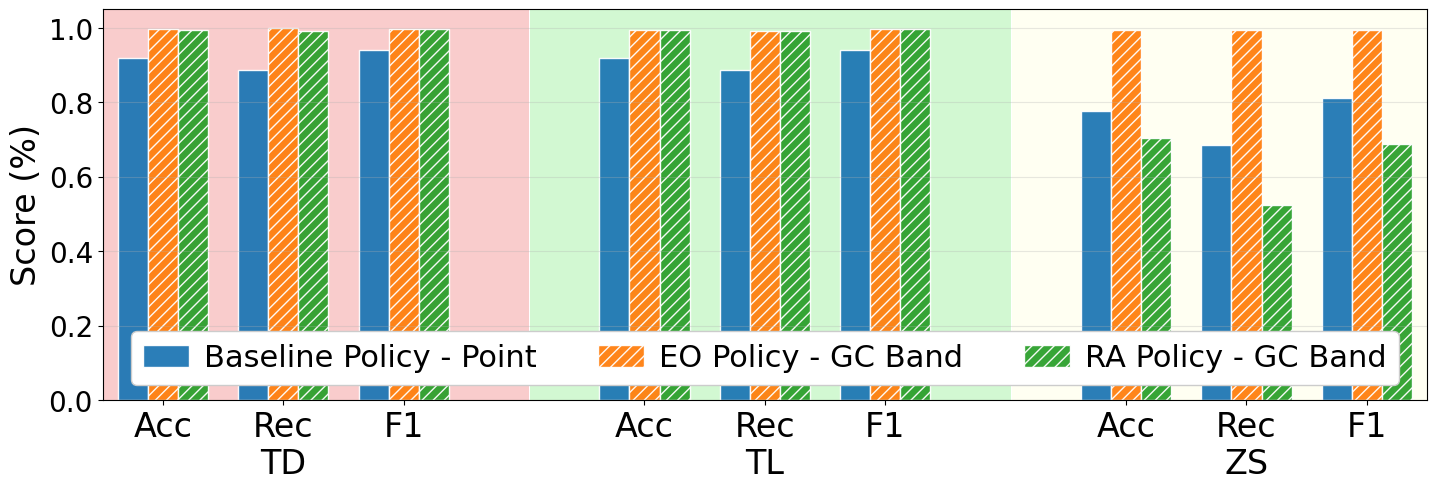

Performance Summary:

TD Model:
  Baseline (Point)              : F1=0.940, Acc=0.920, Rec=0.886
  EO Policy - GC Band           : F1=0.997, Acc=0.996, Rec=1.000, δ=0.0
  RA Policy - GC Band           : F1=0.996, Acc=0.996, Rec=0.993, δ=0.0

TL Model:
  Baseline (Point)              : F1=0.940, Acc=0.920, Rec=0.886
  EO Policy - GC Band           : F1=0.996, Acc=0.996, Rec=0.993, δ=0.1
  RA Policy - GC Band           : F1=0.996, Acc=0.995, Rec=0.992, δ=0.0

ZS Model:
  Baseline (Point)              : F1=0.813, Acc=0.777, Rec=0.685
  EO Policy - GC Band           : F1=0.996, Acc=0.994, Rec=0.996, δ=0.1
  RA Policy - GC Band           : F1=0.689, Acc=0.703, Rec=0.525, δ=0.0


In [34]:
# === Performance Comparison Bar Plot: Policy (color) × Band Type (hatch) ===

INCLUDE_ADAPTIVE = False
font_size = 24

metrics = ['accuracy', 'recall', 'f1_score']
metric_labels = ['Acc', 'Rec', 'F1']

policies = ['regular', 'optimistic', 'safetyfirst']
policy_labels = ['Baseline Policy - Point', 'EO Policy - GC Band', 'RA Policy - GC Band']

policy_colors = {
    'regular':    '#1f77b4',
    'optimistic': '#ff7f0e',
    'safetyfirst':'#2ca02c',
}

model_colors = {'zs': 'lightyellow', 'tl': 'lightgreen', 'db': 'lightcoral'}

band_hatch = {
    'global': '///',
    'point':  ''
}

models = ['db', 'tl', 'zs']
best_configs = {}
for model in models:
    best_configs[model] = {}

    point_data = all_classification_metrics_df[
        (all_classification_metrics_df['model'] == model) &
        (all_classification_metrics_df['band_type'] == 'point')
    ]
    if not point_data.empty:
        best_configs[model]['regular'] = {'point': point_data.iloc[0]}

    for policy in ['optimistic', 'safetyfirst']:
        best_configs[model][policy] = {}
        global_data = all_classification_metrics_df[
            (all_classification_metrics_df['model'] == model) &
            (all_classification_metrics_df['band_type'] == 'global') &
            (all_classification_metrics_df['policy'] == policy)
        ]
        if not global_data.empty:
            best_configs[model][policy]['global'] = global_data.loc[global_data['f1_score'].idxmax()]

fig, ax = plt.subplots(figsize=(15, 5))

n_models = len(models)
n_metrics = len(metrics)
section_width = n_metrics + 1.0

bar_width = 0.25

for i, model in enumerate(models):
    rect = plt.Rectangle((i * section_width - 0.95, 0), section_width - 0.005, 1.05,
                         facecolor=model_colors[model], alpha=0.40, zorder=0)
    ax.add_patch(rect)

for i, model in enumerate(models):
    base_x = i * section_width
    for j, metric in enumerate(metrics):
        metric_x = base_x + j
        bar_positions = []

        if 'regular' in best_configs[model] and 'point' in best_configs[model]['regular']:
            config = best_configs[model]['regular']['point']
            value = float(config.get(metric, np.nan))
            if np.isfinite(value):
                bar_positions.append(('regular', 'point', metric_x - bar_width, value))

        for policy in ['optimistic', 'safetyfirst']:
            if policy in best_configs[model] and 'global' in best_configs[model][policy]:
                config = best_configs[model][policy]['global']
                value = float(config.get(metric, np.nan))
                if np.isfinite(value):
                    offset = 0 if policy == 'optimistic' else bar_width
                    bar_positions.append((policy, 'global', metric_x + offset, value))

        for policy, band_type, bar_x, value in bar_positions:
            hatch = band_hatch.get(band_type, '')
            label = ""
            if i == 0 and j == 0:
                label = policy_labels[policies.index(policy)]
            ax.bar(bar_x, value, bar_width,
                   color=policy_colors[policy], edgecolor='white', linewidth=1,
                   hatch=hatch, alpha=0.95, label=label)

ax.set_ylabel('Score (%)', fontsize=font_size)

x_ticks, x_labels = [], []
for i, model in enumerate(models):
    base_x = i * section_width
    for j, lab in enumerate(metric_labels):
        x_ticks.append(base_x + j)
        x_labels.append(lab)

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, fontsize=font_size)

for i, model in enumerate(models):
    mid_point = i * section_width + (n_metrics - 1) / 2
    display_model = 'TD' if model == 'db' else model.upper()
    ax.text(mid_point, -0.12, display_model, ha='center', va='top', fontsize=font_size,
            transform=ax.get_xaxis_transform())

ax.set_ylim(0, 1.05)
ax.set_xlim(-0.5, (n_models - 1) * section_width + n_metrics - 0.5)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True, alpha=0.3, axis='y')

legend_handles = []
for policy in policies:
    color = policy_colors[policy]
    label = policy_labels[policies.index(policy)]
    if policy == 'regular':
        handle = mpatches.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='white', linewidth=1, alpha=0.95)
    else:
        handle = mpatches.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='white',
                                    hatch='///', linewidth=1, alpha=0.95)
    legend_handles.append((handle, label))

handles, labels = zip(*legend_handles)
legend = ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.0),
                  fontsize=font_size-2, frameon=True, ncol=3, handlelength=1.5,
                  handletextpad=0.5, facecolor='white')
legend.get_frame().set_alpha(1.0)

plt.tight_layout()

os.makedirs('ofc_figures', exist_ok=True)
plt.savefig('ofc_figures/performance_comparison_barplot.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()

# ---- Performance Summary ----
print("Performance Summary:")
print("=" * 70)
for model in ['db', 'tl', 'zs']:
    display_model = 'TD' if model == 'db' else model.upper()
    print(f"\n{display_model} Model:")
    if model in best_configs and 'regular' in best_configs[model] and 'point' in best_configs[model]['regular']:
        config = best_configs[model]['regular']['point']
        print(f"  {'Baseline (Point)':30}: F1={config.get('f1_score', np.nan):.3f}, "
              f"Acc={config.get('accuracy', np.nan):.3f}, Rec={config.get('recall', np.nan):.3f}")
    for policy, policy_label in [('optimistic', 'EO Policy - GC Band'), ('safetyfirst', 'RA Policy - GC Band')]:
        if model in best_configs and policy in best_configs[model] and 'global' in best_configs[model][policy]:
            config = best_configs[model][policy]['global']
            param_str = ""
            if 'delta' in config and pd.notna(config.get('delta')):
                param_str = f", δ={config.get('delta')}"
            print(f"  {policy_label:30}: F1={config.get('f1_score', np.nan):.3f}, "
                  f"Acc={config.get('accuracy', np.nan):.3f}, Rec={config.get('recall', np.nan):.3f}{param_str}")


In [35]:
# Create results directory if it doesn't exist
results_dir = "./results_evaluations"
os.makedirs(results_dir, exist_ok=True)

classification_results_df.to_csv(os.path.join(results_dir, "classification_results_df.csv"), index=False)
classification_metrics_df.to_csv(os.path.join(results_dir, "classification_metrics_df.csv"), index=False)

# Save all_classification_metrics_df for analysis notebooks
policy_dir = os.path.join(results_dir, "policy_param_grid_search")
os.makedirs(policy_dir, exist_ok=True)
all_classification_metrics_df.to_csv(os.path.join(policy_dir, "all_classification_metrics.csv"), index=False)
